In [ ]:
!pip install yfinance pmdarima

In [ ]:
!pip install yfinance

In [ ]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,SimpleRNN
from tensorflow.keras.optimizers import Adam
from keras.utils import plot_model, set_random_seed
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

In [ ]:
set_random_seed(66)

In [ ]:
def fetch_and_clean_stock_data(ticker, start_date, end_date):
    """
    Fetches and cleans stock data for a given ticker symbol from Yahoo Finance.

    Parameters:
    - ticker (str): The stock ticker symbol (e.g., 'TSLA' for Tesla).
    - start_date (str): The start date for the data in 'YYYY-MM-DD' format.
    - end_date (str): The end date for the data in 'YYYY-MM-DD' format.

    Returns:
    - pandas.DataFrame: A cleaned DataFrame with stock data.
    """
    # Fetch data from Yahoo Finance
    data = yf.download(ticker, start=start_date, end=end_date)

    # If the data has a multi-level column index, drop the second level
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.droplevel(1)

    # Rename the columns for better readability
    data.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

    return data

# Fetch data for Tesla and JPMorgan
data_tesla = fetch_and_clean_stock_data('TSLA', start_date="2014-09-19", end_date="2024-09-19")
data_jpm = fetch_and_clean_stock_data('JPM', start_date="2014-09-19", end_date="2024-09-19")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# **DATA** **PREPROCESSING**

In [ ]:
# Display the first few rows for Tesla
print("Tesla Data:")
print(data_tesla.head())

Tesla Data:
                                Open       High        Low      Close  \
Date                                                                    
2014-09-19 00:00:00+00:00  17.288000  17.288000  17.428667  17.018000   
2014-09-22 00:00:00+00:00  16.668667  16.668667  17.068001  16.313999   
2014-09-23 00:00:00+00:00  16.694000  16.694000  16.920000  16.333332   
2014-09-24 00:00:00+00:00  16.809334  16.809334  16.856001  16.469334   
2014-09-25 00:00:00+00:00  16.463333  16.463333  16.997334  16.406668   

                           Adj Close     Volume  
Date                                             
2014-09-19 00:00:00+00:00  17.199333  102163500  
2014-09-22 00:00:00+00:00  17.000000  123211500  
2014-09-23 00:00:00+00:00  16.348000   84880500  
2014-09-24 00:00:00+00:00  16.741333   56242500  
2014-09-25 00:00:00+00:00  16.834667   72513000  


In [ ]:
# Display the first few rows for JPMorgan
print("\nJPMorgan Data:")
print(data_jpm.head())


JPMorgan Data:
                                Open       High        Low      Close  \
Date                                                                    
2014-09-19 00:00:00+00:00  46.047890  61.110001  61.849998  60.980000   
2014-09-22 00:00:00+00:00  45.897190  60.910000  61.450001  60.799999   
2014-09-23 00:00:00+00:00  45.919807  60.939999  61.400002  60.770000   
2014-09-24 00:00:00+00:00  46.439732  61.630001  61.639999  61.020000   
2014-09-25 00:00:00+00:00  45.324512  60.150002  61.500000  60.150002   

                           Adj Close    Volume  
Date                                            
2014-09-19 00:00:00+00:00  61.740002  18739300  
2014-09-22 00:00:00+00:00  60.939999  13225200  
2014-09-23 00:00:00+00:00  60.820000  14328800  
2014-09-24 00:00:00+00:00  61.180000  13728200  
2014-09-25 00:00:00+00:00  61.490002  16340100  


In [ ]:
def analyze_data(data):
    """
    Analyzes a DataFrame by providing descriptive statistics and data info.

    Parameters:
    - data (pandas.DataFrame): The DataFrame to analyze.

    Returns:
    - None
    """
    print("### Descriptive Statistics ###")
    print(data.describe())
    print("\n### Dataset Info ###")
    print(data.info())
    print("\n### Columns in the Dataset ###")
    print(data.columns)

# Example usage with Tesla data
print("Analysis for Tesla Data:")
analyze_data(data_tesla)



Analysis for Tesla Data:
### Descriptive Statistics ###
              Open         High          Low        Close    Adj Close  \
count  2516.000000  2516.000000  2516.000000  2516.000000  2516.000000   
mean    107.142733   107.142733   109.523028   104.667384   107.169883   
std     109.365515   109.365515   111.898320   106.794317   109.458746   
min       9.578000     9.578000    10.331333     9.403333     9.488000   
25%      16.702667    16.702667    16.933332    16.465666    16.693166   
50%      23.702000    23.702000    24.068000    23.396000    23.735333   
75%     211.875004   211.875004   216.714996   206.374996   210.616673   
max     409.970001   409.970001   414.496674   405.666656   411.470001   

             Volume  
count  2.516000e+03  
mean   1.122561e+08  
std    7.411750e+07  
min    1.062000e+07  
25%    6.678508e+07  
50%    9.289395e+07  
75%    1.299176e+08  
max    9.140820e+08  

### Dataset Info ###
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516

In [ ]:
print("\nAnalysis for JPMorgan Data:")
analyze_data(data_jpm)


Analysis for JPMorgan Data:
### Descriptive Statistics ###
              Open         High          Low        Close    Adj Close  \
count  2516.000000  2516.000000  2516.000000  2516.000000  2516.000000   
mean    101.125006   113.663621   114.696725   112.593526   113.638394   
std      41.444098    38.485472    38.786621    38.149586    38.456315   
min      41.518131    53.070000    53.910000    50.070000    53.900002   
25%      70.143858    86.715000    87.177500    85.857502    86.430000   
50%      93.914104   110.965000   111.890003   109.845001   110.990002   
75%     132.535023   139.580002   140.715004   138.212505   139.570000   
max     223.430817   224.800003   225.479996   221.929993   222.500000   

             Volume  
count  2.516000e+03  
mean   1.412683e+07  
std    6.528012e+06  
min    3.220500e+06  
25%    9.869775e+06  
50%    1.274160e+07  
75%    1.645210e+07  
max    5.619230e+07  

### Dataset Info ###
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 

In [ ]:
def check_data_quality(data):
    """
    Checks the DataFrame for duplicate and missing values.

    Parameters:
    - data (pandas.DataFrame): The dataset to check.

    Returns:
    - None: Prints the results of the checks.
    """
    # Check for duplicates
    duplicates = data.duplicated()
    if duplicates.any():
        print("The DataFrame has duplicates.")
        print(f"Number of duplicate rows: {duplicates.sum()}")
    else:
        print("The DataFrame does not have duplicates.")
    print("\n" + "="*50 + "\n")

    # Check for missing values
    missing_values = data.isnull().sum()
    print("Missing Values:")
    print(missing_values)
    print("\n" + "="*50 + "\n")

# Example usage
check_data_quality(data_tesla)  # Call the function with Tesla data
check_data_quality(data_jpm)    # Call the function with JPMorgan data


The DataFrame does not have duplicates.


Missing Values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


The DataFrame does not have duplicates.


Missing Values:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64




In [ ]:
def remove_outliers(data, column='Close', threshold=3):
    """
    Detects and removes outliers in the daily returns of a given column
    using z-scores.

    Parameters:
    - data (pandas.DataFrame): The dataset containing the column.
    - column (str): The column name to analyze (default is 'Close').
    - threshold (float): The z-score threshold to identify outliers (default is 3).

    Returns:
    - pandas.DataFrame: The dataset with outliers removed.
    - int: The number of outliers removed.
    """
    # Calculate daily returns
    close_prices = data[column]
    daily_returns = close_prices.pct_change()

    # Calculate z-scores for daily returns
    z_scores = (daily_returns - daily_returns.mean()) / daily_returns.std()

    # Identify outliers based on the threshold
    outliers = z_scores[abs(z_scores) > threshold]

    # Remove rows corresponding to outliers from the dataset
    cleaned_data = data[~data.index.isin(outliers.index)]


    return cleaned_data, len(outliers)

# Example usage
tesla_cleaned_data, tesla_outliers_removed = remove_outliers(data_tesla, column='Close', threshold=3)
jpm_cleaned_data, jpm_outliers_removed = remove_outliers(data_jpm, column='Close', threshold=3)

# Print the results
print(f"Telsa: {tesla_outliers_removed} outliers removed.")
print(f"JP Morgan: {jpm_outliers_removed} outliers removed.")





Telsa: 46 outliers removed.
JP Morgan: 35 outliers removed.


# **EXPLORATORY** **DATA** **ANALYSIS**

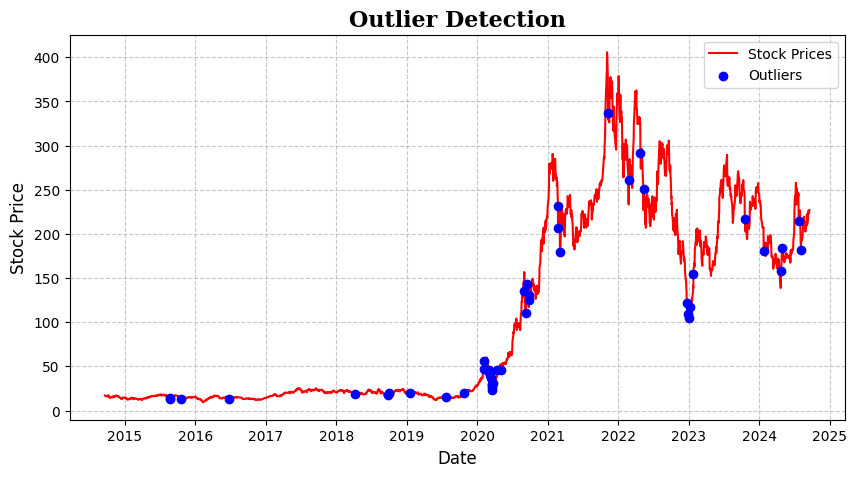

Number of outliers: 46


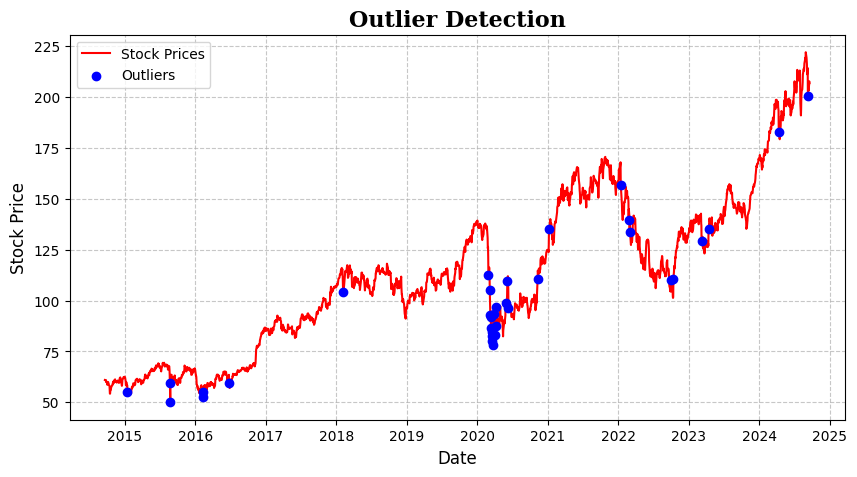

Number of outliers: 35


In [ ]:
def plot_outliers(data, column='Close', threshold=3):
    """
    Plots stock prices with identified outliers and displays the number of outliers.

    Parameters:
    - data (pandas.DataFrame): The dataset containing the column.
    - column (str): The column name to analyze (default is 'Close').
    - threshold (float): The z-score threshold to identify outliers (default is 3).

    Returns:
    - None
    """
    # Calculate daily returns
    close_prices = data[column]
    daily_returns = close_prices.pct_change()

    # Calculate z-scores for daily returns
    z_scores = (daily_returns - daily_returns.mean()) / daily_returns.std()

    # Identify outliers based on the threshold
    outliers = z_scores[abs(z_scores) > threshold]

    # Plot stock prices with outliers
    plt.figure(figsize=(10, 5))
    plt.plot(close_prices.index, close_prices.values, label='Stock Prices', color='red')
    plt.scatter(outliers.index, close_prices[outliers.index], color='blue', label='Outliers', zorder=5)
    plt.title('Outlier Detection', fontsize=16, fontweight='bold', fontfamily='serif')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Stock Price', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    print(f"Number of outliers: {len(outliers)}")

# Example usage
plot_outliers(data_tesla, column='Close', threshold=3)
plot_outliers(data_jpm, column='Close', threshold=3)


**OPENING** **PRICE** **PLOT**

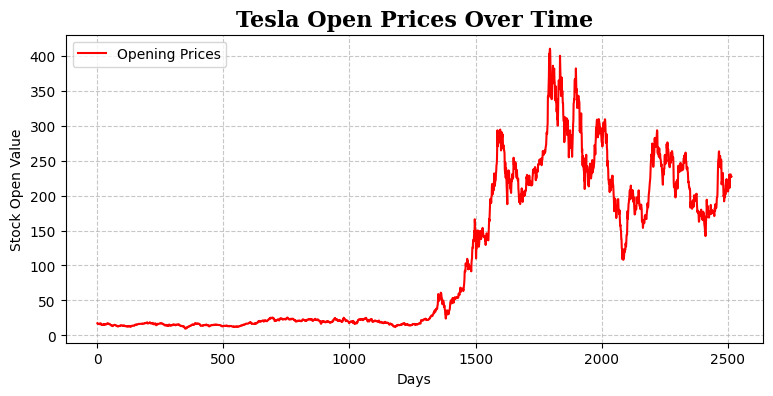

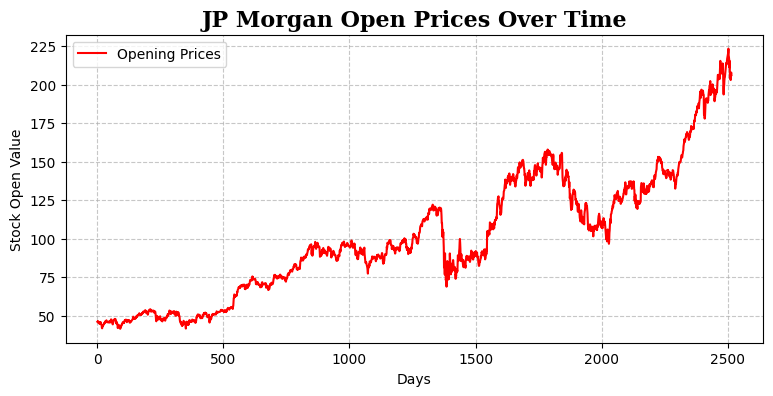

In [ ]:
def plot_opening_prices(data, company_name):
    """
    Plots the opening prices of a stock to inspect trends.

    Parameters:
    - data: Pandas Series containing opening prices.
    - company_name: String representing the company name for plot labeling.

    Returns:
    - None
    """
    plt.figure(figsize=(9, 4))
    plt.plot(data, color='r', label='Opening Prices')
    plt.xlabel('Days')
    plt.ylabel('Stock Open Value')
    plt.title(f"{company_name} Open Prices Over Time", fontsize=16, fontweight='bold', fontfamily='serif')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper left', fontsize=10)
    plt.show()

# Extract 'Open' prices for Tesla and JP Morgan from their respective DataFrames
tesla_open_prices = data_tesla.reset_index()['Open']
jpm_open_prices = data_jpm.reset_index()['Open']

# Example function calls
plot_opening_prices(tesla_open_prices, 'Tesla')
plot_opening_prices(jpm_open_prices, 'JP Morgan')

**CLOSING** **PRICE** **PLOT**

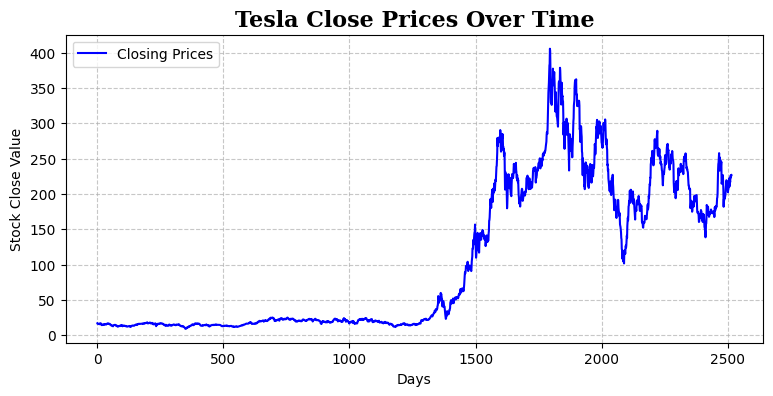

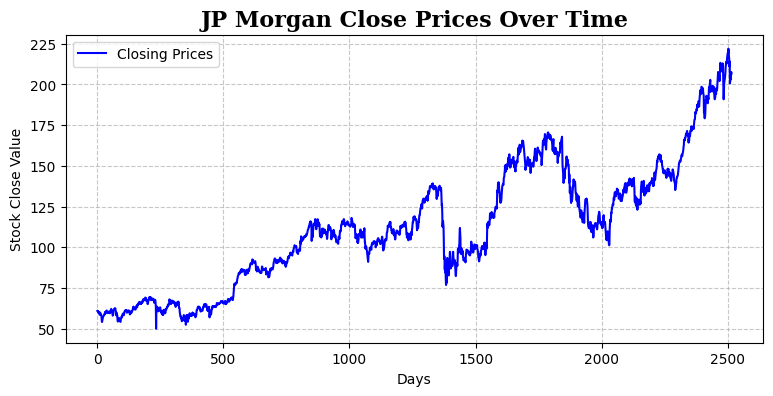

In [ ]:
def plot_closing_prices(data, company_name):
    """
    Plots the closing prices of a stock to inspect trends.

    Parameters:
    - data: Pandas Series containing closing prices.
    - company_name: String representing the company name for plot labeling.

    Returns:
    - None
    """
    plt.figure(figsize=(9, 4))
    plt.plot(data, color='b', label='Closing Prices')
    plt.xlabel('Days')
    plt.ylabel('Stock Close Value')
    plt.title(f"{company_name} Close Prices Over Time", fontsize=16, fontweight='bold', fontfamily='serif')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper left', fontsize=10)
    plt.show()

# Extract 'Close' prices for Tesla and JP Morgan from their respective DataFrames
tesla_close_prices = data_tesla.reset_index()['Close']
jpm_close_prices = data_jpm.reset_index()['Close']

# Example function calls for closing prices
plot_closing_prices(tesla_close_prices, 'Tesla')
plot_closing_prices(jpm_close_prices, 'JP Morgan')

**VOLATILITY** **PLOT**

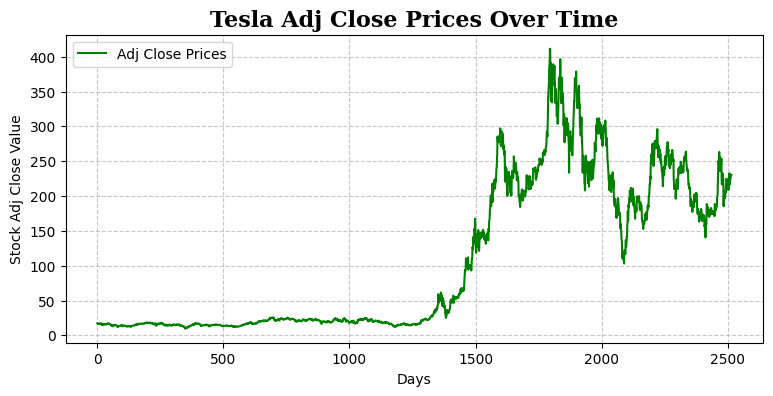

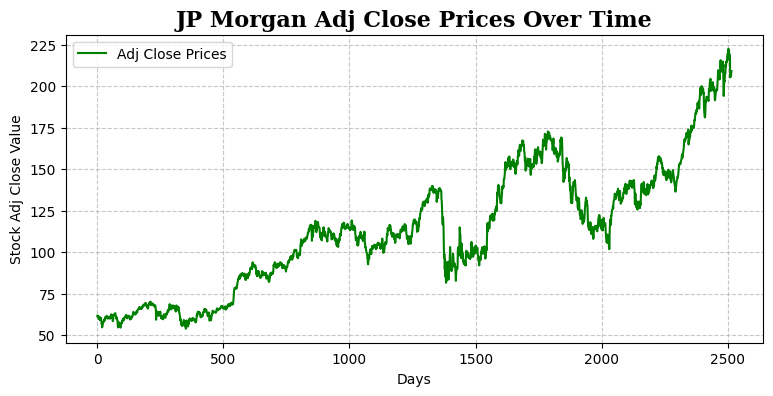

In [ ]:
def plot_adj_closing_prices(data, company_name):
    """
    Plots the adjusted closing prices of a stock to inspect trends.

    Parameters:
    - data: Pandas Series containing adjusted closing prices.
    - company_name: String representing the company name for plot labeling.

    Returns:
    - None
    """
    plt.figure(figsize=(9, 4))
    plt.plot(data, color='g', label='Adj Close Prices')
    plt.xlabel('Days')
    plt.ylabel('Stock Adj Close Value')
    plt.title(f"{company_name} Adj Close Prices Over Time", fontsize=16, fontweight='bold', fontfamily='serif')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper left', fontsize=10)
    plt.show()

# Extract 'Adj Close' prices for Tesla and JP Morgan from their respective DataFrames
tesla_adj_close_prices = data_tesla.reset_index()['Adj Close']
jpm_adj_close_prices = data_jpm.reset_index()['Adj Close']

# Example function calls for adjusted closing prices
plot_adj_closing_prices(tesla_adj_close_prices, 'Tesla')
plot_adj_closing_prices(jpm_adj_close_prices, 'JP Morgan')


**STOCK** **PERFORMANCE** **AND** **VOLUME** **OVER** **TIME**

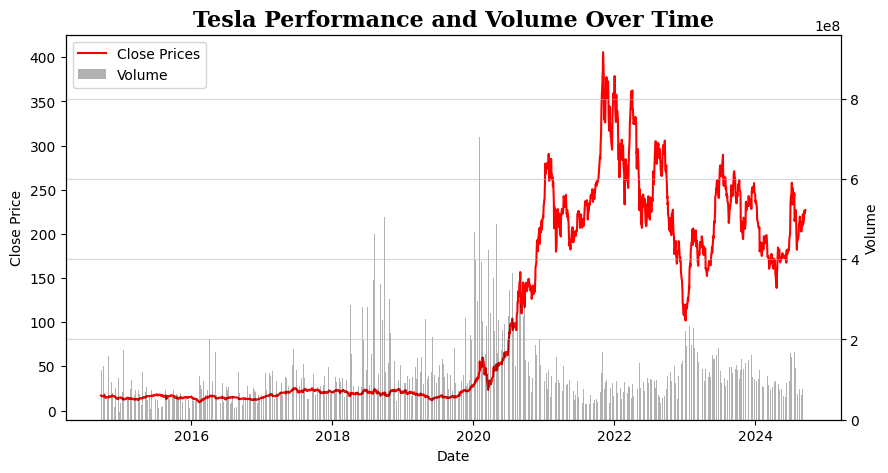

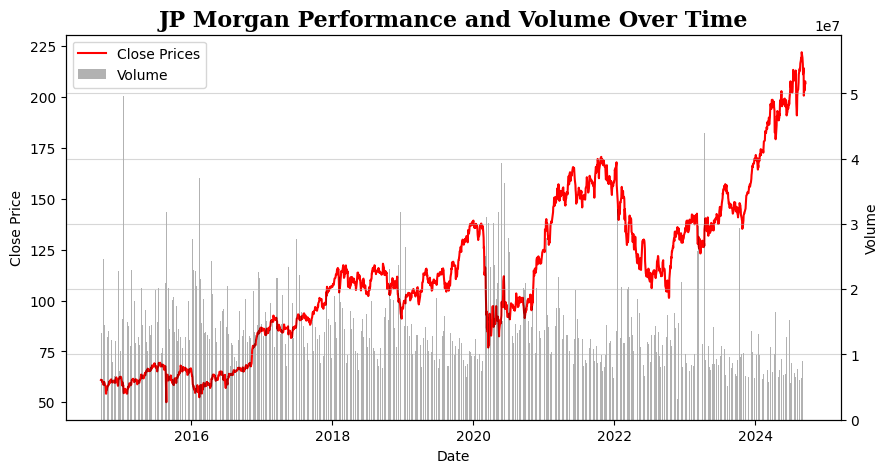

In [ ]:
 #Function to plot stock performance and volume
def plot_stock_volume(data, stock_name='Stock'):
    """
    Plots the stock performance and volume over time.

    Parameters:
    - data (pandas.DataFrame): The dataset containing 'Close' prices and 'Volume'.
    - stock_name (str): The name of the stock for labeling.

    Returns:
    - None
    """
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot 'Close' prices on the first y-axis
    ax1.plot(data.index, data['Close'], label='Close Prices', color='red')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # Create second y-axis for volume data
    ax2 = ax1.twinx()
    ax2.bar(data.index, data['Volume'], label='Volume', color='black', alpha=0.3)
    ax2.set_ylabel('Volume', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Title and legend
    plt.title(f'{stock_name} Performance and Volume Over Time', fontsize=16, fontweight='bold', fontfamily='serif')
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax1.legend(lines, labels, loc='upper left')
    plt.grid(alpha=0.5)
    plt.show()

# Example function calls
plot_stock_volume(data_tesla, 'Tesla')
plot_stock_volume(data_jpm, 'JP Morgan')

**ROBUST** **SCALING**

In [ ]:
# Scale the data to a range between 0 and 1 as LSTMs are sensitive to scale
scaler = RobustScaler()
scaled_data_tesla = scaler.fit_transform(data_tesla['Close'].values.reshape(-1,1))
scaled_data_jpm = scaler.fit_transform(data_jpm['Close'].values.reshape(-1,1))

**TIME** **SERIES** **GENERATOR**

In [ ]:
# Create the time series data structure using tesla
look_back = 50
train_size = int(len(scaled_data_tesla) * 0.80)
train_data = scaled_data_tesla[:train_size]
test_data = scaled_data_tesla[train_size - look_back:]

train_generator = TimeseriesGenerator(train_data, train_data,
                                     length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(test_data, test_data,
                                     length=look_back, batch_size=1)


**NUMPY** **ARRAY** **CREATION**

In [ ]:
def create_dataset(dataset, time_step = 1):
  """
  Create sequences of 'time_step' consecutive values from the input time
  series 'dataset'.
  Parameters:
  - dataset (numpy.ndarray): Input time series data.
  - time_step (int): Number of consecutive time steps in each sequence.
  Returns:
  - numpy.ndarray, numpy.ndarray: Tuple containing dataX and dataY.
  """
  dataX,dataY = [],[]
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i + time_step,0])
  return np.array(dataX),np.array(dataY)

**SPLITTING** **DATA** **Tesla**

In [ ]:
# Call the function to split the data into input-output datasets
# with a time step of 50
time_step = 50
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [ ]:
# Display the shapes of the training and testing datasets
print(X_train.shape)
print(X_test.shape)

(1961, 50)
(503, 50)


# **LONG** **SHORT**-**TERM** **MEMORY**(**LSTM**)

In [ ]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=True,
                    input_shape =(X_train.shape[1],1)))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile and fit LSTM model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(train_generator, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/10
 1/99 ━━━━━━━━━━━━━━━━━━━━ 9:22 6s/step - loss: 0.0025

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 173ms/step - loss: 0.0675 - val_loss: 0.0300
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - loss: 0.0191 - val_loss: 0.2265
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 170ms/step - loss: 0.0259 - val_loss: 0.0137
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 171ms/step - loss: 0.0037 - val_loss: 0.0108
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - loss: 0.0051 - val_loss: 0.1211
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - loss: 0.0141 - val_loss: 0.0179
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - loss: 0.0096 - val_loss: 0.0326
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - loss: 0.0062 - val_loss: 0.0183
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - loss: 0.0128 - val_loss: 0.0072
Epoch 10/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 30s 265ms/step - loss: 0.0103 - val_loss: 0.0071


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

def build_rnn_model(input_shape):
    """
    Builds a Simple RNN-based model for time series prediction.

    Parameters:
    - input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
    - model (Sequential): Compiled RNN model.
    """
    rnn_model = Sequential()
    rnn_model.add(SimpleRNN(128, return_sequences=True, input_shape=input_shape))
    rnn_model.add(SimpleRNN(64, return_sequences=True))
    rnn_model.add(SimpleRNN(32))
    rnn_model.add(Dense(1))  # Output layer for regression task

    # Compile the model
    rnn_model.compile(loss='mean_squared_error', optimizer='adam')
    return rnn_model

# Example: Build and train the RNN model
input_shape = (train_generator.length, 1)  # Assuming univariate time series
rnn_model = build_rnn_model(input_shape)

# Train the RNN model
history = rnn_model.fit(
    train_generator,
    epochs=10,
    batch_size=32,
    validation_data=test_generator,
    verbose=1
)



Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - loss: 0.2521 - val_loss: 0.0449
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 0.0176 - val_loss: 0.0081
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 0.0089 - val_loss: 0.0085
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 0.0306 - val_loss: 0.0100
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0041 - val_loss: 0.0434
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0113 - val_loss: 0.0058
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0.0061 - val_loss: 0.0103
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 10/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 0.0156 - val_loss: 0.0066


In [ ]:
from tensorflow.keras.layers import GRU, Dense

# Build the GRU model
def build_gru_model(input_shape):
    """
    Builds a GRU-based RNN model for time series prediction.

    Parameters:
    - input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
    - model (Sequential): Compiled GRU model.
    """
    gru_model = Sequential()
    gru_model.add(GRU(128, return_sequences=True, input_shape=input_shape))
    gru_model.add(GRU(64, return_sequences=True))
    gru_model.add(GRU(32))
    gru_model.add(Dense(1))  # Output layer for regression task

    # Compile the model
    gru_model.compile(loss='mean_squared_error', optimizer='adam')
    return gru_model

# Example: Build and train the GRU model
input_shape = (train_generator.length, 1)  # Assuming univariate time series
gru_model = build_gru_model(input_shape)

# Train the GRU model
gru_model.fit(train_generator, epochs=10, batch_size=32, validation_data=test_generator)


Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 45s 257ms/step - loss: 0.0751 - val_loss: 0.0077
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 30s 302ms/step - loss: 0.0027 - val_loss: 0.0100
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 45s 346ms/step - loss: 0.0245 - val_loss: 0.0061
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 28s 283ms/step - loss: 0.0014 - val_loss: 0.0047
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 25s 253ms/step - loss: 0.0018 - val_loss: 0.0204
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 49s 331ms/step - loss: 0.0049 - val_loss: 0.0026
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 31s 233ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 29s 274ms/step - loss: 8.4600e-04 - val_loss: 0.0086
Epoch 10/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 31s 309ms/step - loss: 0.0015 - val_loss: 0.0251


In [ ]:
# Predicting on the dataset with our models
rnn_predictions = rnn_model.predict(test_generator)
lstm_predictions = lstm_model.predict(test_generator)
gru_predictions = gru_model.predict(test_generator)

# Inverting out models
rnn_predictions = scaler.inverse_transform(rnn_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
gru_predictions = scaler.inverse_transform(gru_predictions)

actual_prices = scaler.inverse_transform(test_data[look_back:])

504/504 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
504/504 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step
504/504 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step


In [ ]:
vals1 = Y_test.reshape(-1, 1)
actual_values = scaler.inverse_transform(vals1)

**MSE**,**MAE** **AND** **RMSE** **OF** **LSTM** **GRU** **AND** **RNN** **MODELS**

In [ ]:

def calculate_model_errors(actual_values, predictions):
    """
    Calculates MSE, MAE, and RMSE of the models.

    Parameters:
    - actual_values: NumPy array containing the actual values
    - predictions: NumPy array containing the predicted values

    Returns:
    - tuple: (mse, mae, rmse)
      - mse: Mean Squared Error
      - mae: Mean Absolute Error
      - rmse: Root Mean Squared Error
    """
    # Calculate MSE
    mse = mean_squared_error(actual_values, predictions[:-1])

    # Calculate MAE
    mae = np.mean(np.abs(actual_values - predictions[:-1]))

    # Calculate RMSE
    rmse = np.sqrt(mse)

    return mse, mae, rmse

#  function call
rnn_mse, rnn_mae, rnn_rmse = calculate_model_errors(actual_values, rnn_predictions)
lstm_mse, lstm_mae, lstm_rmse = calculate_model_errors(actual_values, lstm_predictions)
gru_mse, gru_mae, gru_rmse = calculate_model_errors(actual_values, gru_predictions)

print(f'Mean Squared Error of RNN Model: {rnn_mse}')
print(f'Mean Absolute Error of RNN Model: {rnn_mae}')
print(f'Root Mean Squared Error of RNN Model: {rnn_rmse}')

print(f'Mean Squared Error of LSTM Model: {lstm_mse}')
print(f'Mean Absolute Error of LSTM Model: {lstm_mae}')
print(f'Root Mean Squared Error of LSTM Model: {lstm_rmse}')

print(f'Mean Squared Error of GRU Model: {gru_mse}')
print(f'Mean Absolute Error of GRU Model: {gru_mae}')
print(f'Root Mean Squared Error of GRU Model: {gru_rmse}')

Mean Squared Error of RNN Model: 18.049077835894195
Mean Absolute Error of RNN Model: 3.5595880045826718
Root Mean Squared Error of RNN Model: 4.248420628409361
Mean Squared Error of LSTM Model: 19.352616707704016
Mean Absolute Error of LSTM Model: 3.431718021077157
Root Mean Squared Error of LSTM Model: 4.39916090950354
Mean Squared Error of GRU Model: 68.76827571841721
Mean Absolute Error of GRU Model: 7.855682611139059
Root Mean Squared Error of GRU Model: 8.292663969944593


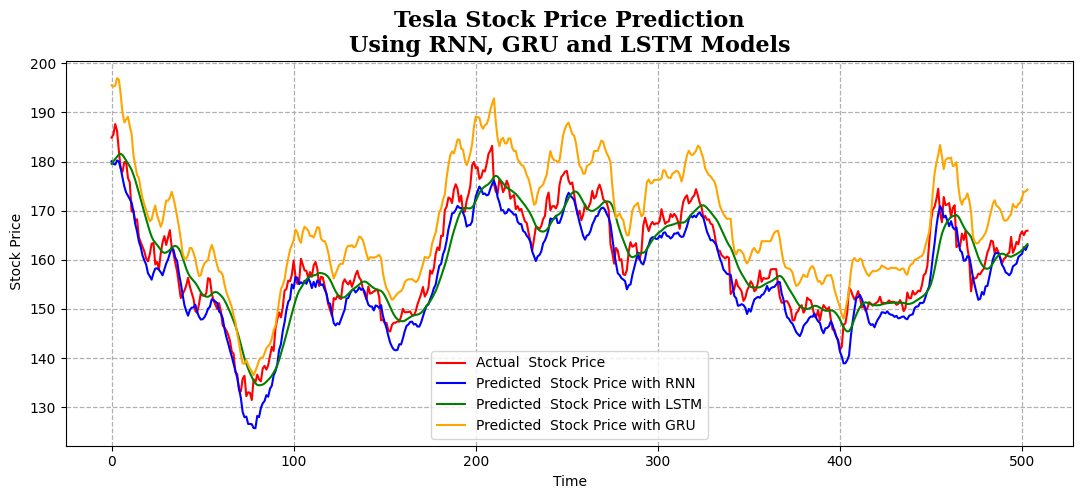

In [ ]:
def plot_predictions(true_data, rnn_predictions, lstm_predictions,gru_predictions,stock_name='Stock'):
    """
    Plots the true data along with predictions from RNN and LSTM models.

    Parameters:
    - true_data: Pandas Series or NumPy array containing the true data
    - rnn_predictions: Pandas Series or NumPy array containing the predictions from RNN model
    - lstm_predictions: Pandas Series or NumPy array containing the predictions from LSTM model
    - gru_predictions: Pandas Series or NumPy array containing the predictions from GRU model

    Returns:
    - None
    """
    plt.figure(figsize=(13, 5))
    plt.plot(true_data, color='red', label='Actual  Stock Price')
    plt.plot(rnn_predictions, color='blue', label='Predicted  Stock Price with RNN')
    plt.plot(lstm_predictions, color='green', label='Predicted  Stock Price with LSTM')
    plt.plot(gru_predictions, color='orange', label='Predicted  Stock Price with GRU')
    # Title, labels, and legend
    plt.title(f'{stock_name} Stock Price Prediction\nUsing RNN, GRU and LSTM Models', fontsize=16, fontweight='bold', fontfamily='serif')
    plt.xlabel('Time')
    plt.ylabel(' Stock Price')
    plt.grid(which='both', linestyle='--', linewidth=0.9)
    plt.legend()

    # Saving the plot
    plt.savefig('stock_price_prediction_RNN_LSTM.png', dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()

# Example function call with actual data
# Replace actual_prices, rnn_predictions, and lstm_predictions with your actual data
plot_predictions(actual_prices, rnn_predictions, lstm_predictions,gru_predictions,'Tesla')

Finded that LSTM have less error comparing with other 2 models.so predicting the next 25 days of jp morgan stock using LSTM model.

**FORECASTING**

In [ ]:
def pred_future_stock(model, base_data, days_to_predict,
                      scaler, look_back=2000):
  """
  Predict future stock values using the given LSTM 'model'.
  Parameters:
  - model: Trained LSTM model.
  - base_data: Time series data used as the starting point for prediction.
  - days_to_predict: Number of future days to predict.
  - scaler: Scaler used for data normalization.
  - look_back: Number of past days to consider for each prediction.
  Returns:
  - numpy.ndarray: Predicted future stock values.
  """
  # Start with the last days of the base data
  input_data = base_data[-look_back:].reshape(1, look_back, 1)

  # Predict future days
  future_predictions = []

  for _ in range(days_to_predict):

    # Make a prediction
    prediction = model.predict(input_data)

    # Append the prediction
    future_predictions.append(prediction[0, 0])

    # Update the input data to include the prediction and
    # exclude the oldest data point.
    # Correctly reshape the prediction to
    # (1, 1, 1) before appending
    input_data = np.append(input_data[:, 1:, :],
                           prediction.reshape(1, 1, 1), axis=1)

  # Invert the scaling
  reshaped = np.array(future_predictions).reshape(-1, 1)
  future_predictions = scaler.inverse_transform(reshaped)

  return future_predictions

In [ ]:
# predicting the stock price by calling the function
days_to_pred = 25
future_days = pred_future_stock(rnn_model, scaled_data_tesla, days_to_pred,
                                scaler, look_back)
print(future_days.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
(25, 1)


In [ ]:
# predicting the stock price by calling the function
days_to_pred = 365
future_days = pred_future_stock(rnn_model, scaled_data_tesla, days_to_pred,
                                scaler, look_back)
print(future_days.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

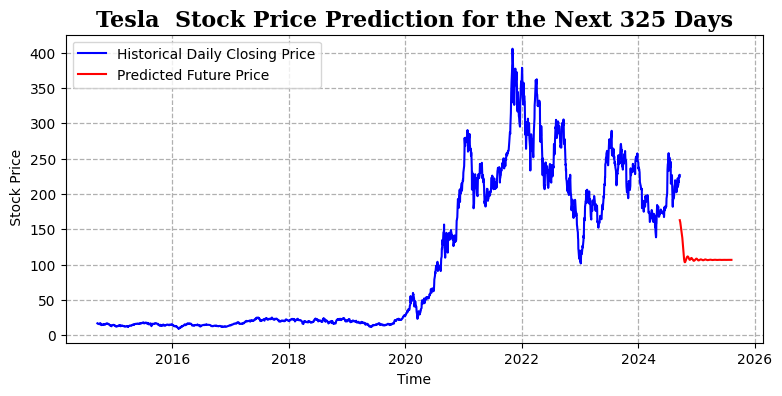

In [ ]:
def plot_future_predictions(data, future_days,stock_name='Stock'):
    """
    Plots the predicted future prices along with historical data.

    Parameters:
    - data: Pandas DataFrame containing historical data with index as datetime
    - future_days: NumPy array containing predicted future prices

    Returns:
    - None
    """
    # Adjusting the dimensions of future_days array
    future_days = future_days.squeeze()

    # Plotting the predictions
    predicted_dates = pd.date_range(start=data.index[-1], periods=len(future_days))
    plt.figure(figsize=(9, 4))
    plt.plot(data.index, data['Close'], color='blue', label='Historical Daily Closing Price')
    plt.plot(predicted_dates, future_days, color='red', label='Predicted Future Price')
    plt.title(f'{stock_name}  Stock Price Prediction for the Next {len(future_days)} Days',
              fontsize=16, fontweight='bold', fontfamily='serif')
    plt.xlabel('Time')
    plt.ylabel(' Stock Price')
    plt.grid(which='both', linestyle='--', linewidth=0.9)
    plt.legend()
    plt.show()

# Example function call with actual data
# Replace data and future_days with your actual data
plot_future_predictions(data_tesla, future_days,'Tesla')

Trend  is showing an downward trend for nrxt 25 days

In [ ]:
# Create the time series data structure using tesla
look_back = 50
train_size = int(len(scaled_data_jpm) * 0.80)
train_data_jpm = scaled_data_jpm[:train_size]
test_data_jpm = scaled_data_jpm[train_size - look_back:]

train_generator_jpm = TimeseriesGenerator(train_data_jpm, train_data_jpm,
                                     length=look_back, batch_size=20)
test_generator_jpm = TimeseriesGenerator(test_data_jpm, test_data_jpm,
                                     length=look_back, batch_size=1)

In [ ]:
# Call the function to split the data into input-output datasets
# with a time step of 50
time_step = 50
X_train,Y_train =  create_dataset(train_data_jpm,time_step)
X_test,Y_test =  create_dataset(test_data_jpm,time_step)

In [ ]:
# Display the shapes of the training and testing datasets
print(X_train.shape)
print(X_test.shape)

(1961, 50)
(503, 50)


In [ ]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=True,
                    input_shape =(X_train.shape[1],1)))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1))
# Compile and fit LSTM model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(train_generator, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 36s 292ms/step - loss: 0.0481 - val_loss: 0.0636
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 242ms/step - loss: 0.0112 - val_loss: 0.0339
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 174ms/step - loss: 0.0094 - val_loss: 0.0493
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - loss: 0.0071 - val_loss: 0.0180
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - loss: 0.0092 - val_loss: 0.0825
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - loss: 0.0091 - val_loss: 0.0521
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 187ms/step - loss: 0.0053 - val_loss: 0.0109
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - loss: 0.0064 - val_loss: 0.0383
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 210ms/step - loss: 0.0039 - val_loss: 0.0117
Epoch 10/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 36s 161ms/step - loss: 0.0052 - val_loss: 0.0550


In [ ]:
#  the  build GRU model
input_shape = (train_generator_jpm.length, 1)  # Assuming univariate time series
gru_model = build_gru_model(input_shape)

# Train the GRU model function call
gru_model.fit(train_generator_jpm, epochs=10, batch_size=32, validation_data=test_generator_jpm)

Epoch 1/10
 2/99 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 0.0176 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 187ms/step - loss: 0.0155 - val_loss: 0.0102
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 22s 200ms/step - loss: 0.0049 - val_loss: 0.0264
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step - loss: 0.0039 - val_loss: 0.0051
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - loss: 0.0035 - val_loss: 0.0133
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - loss: 0.0028 - val_loss: 0.0092
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - loss: 0.0025 - val_loss: 0.0169
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 275ms/step - loss: 0.0022 - val_loss: 0.0087
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 25s 256ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 10/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - loss: 0.0025 - val_loss: 0.0179


In [ ]:
input_shape = (train_generator_jpm.length, 1)  # Assuming univariate time series
rnn_model = build_rnn_model(input_shape)

# Train the RNN model
history = rnn_model.fit(train_generator,epochs=10,batch_size=32,
    validation_data=test_generator,
    verbose=1
)

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 0.1677 - val_loss: 0.0379
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 0.0108 - val_loss: 0.0061
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0086 - val_loss: 0.0352
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - loss: 0.0531 - val_loss: 0.0108
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.0527 - val_loss: 0.0364
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0137 - val_loss: 0.0045
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0017 - val_loss: 0.0037
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 10/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0046 - val_loss: 0.0028


In [ ]:
# Predicting on the dataset with our models
rnn_predictions = rnn_model.predict(test_generator_jpm)
lstm_predictions = lstm_model.predict(test_generator_jpm)
gru_predictions = gru_model.predict(test_generator_jpm)

# Inverting out models
rnn_predictions = scaler.inverse_transform(rnn_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
gru_predictions = scaler.inverse_transform(gru_predictions)

actual_prices = scaler.inverse_transform(test_data_jpm[look_back:])

504/504 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
504/504 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step
504/504 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step


In [ ]:
vals1 = Y_test.reshape(-1, 1)
actual_values = scaler.inverse_transform(vals1)

In [ ]:
#  function call
rnn_mse, rnn_mae, rnn_rmse = calculate_model_errors(actual_values, rnn_predictions)
lstm_mse, lstm_mae, lstm_rmse = calculate_model_errors(actual_values, lstm_predictions)
gru_mse, gru_mae, gru_rmse = calculate_model_errors(actual_values, gru_predictions)

print(f'Mean Squared Error of RNN Model: {rnn_mse}')
print(f'Mean Absolute Error of RNN Model: {rnn_mae}')
print(f'Root Mean Squared Error of RNN Model: {rnn_rmse}')

print(f'Mean Squared Error of LSTM Model: {lstm_mse}')
print(f'Mean Absolute Error of LSTM Model: {lstm_mae}')
print(f'Root Mean Squared Error of LSTM Model: {lstm_rmse}')

print(f'Mean Squared Error of GRU Model: {gru_mse}')
print(f'Mean Absolute Error of GRU Model: {gru_mae}')
print(f'Root Mean Squared Error of GRU Model: {gru_rmse}')

Mean Squared Error of RNN Model: 9.557543859391929
Mean Absolute Error of RNN Model: 2.3127730807537588
Root Mean Squared Error of RNN Model: 3.091527754912113
Mean Squared Error of LSTM Model: 150.74411014676284
Mean Absolute Error of LSTM Model: 11.078850596372934
Root Mean Squared Error of LSTM Model: 12.277789302100066
Mean Squared Error of GRU Model: 48.769479957473315
Mean Absolute Error of GRU Model: 5.4626601353791315
Root Mean Squared Error of GRU Model: 6.983514871286043


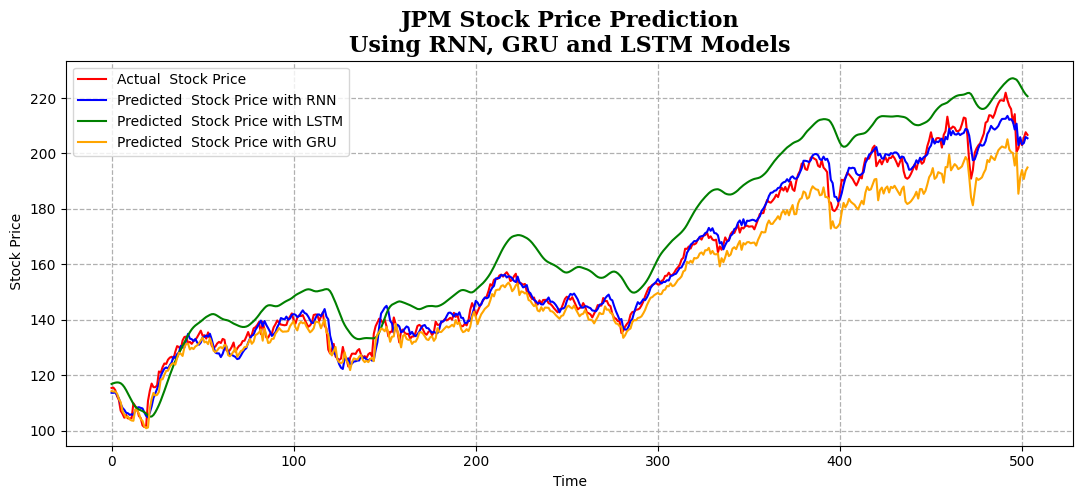

In [ ]:
# Example function call with actual data
# Replace actual_prices, rnn_predictions, and lstm_predictions with your actual data
plot_predictions(actual_prices, rnn_predictions, lstm_predictions,gru_predictions,'JPM')

It is showing an upward trend for nrxt 25 days,which is a good news forpotential investors.

In [ ]:
# predicting the stock price by calling the function
days_to_pred = 25
future_days = pred_future_stock(rnn_model, scaled_data_jpm, days_to_pred,
                                scaler, look_back)
print(future_days.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
(25, 1)


In [ ]:
# predicting the stock price by calling the function
days_to_pred = 365
future_days = pred_future_stock(rnn_model, scaled_data_jpm, days_to_pred,
                                scaler, look_back)
print(future_days.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

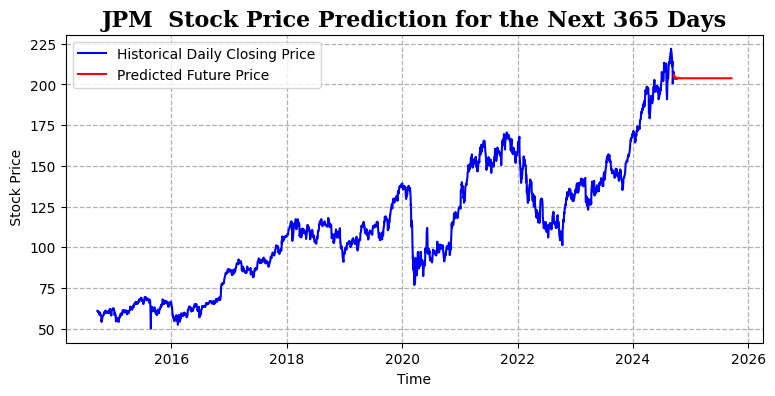

In [ ]:
# Example function call with actual data
# Replace data and future_days with your actual data
plot_future_predictions(data_jpm, future_days,'JPM')

**ARIMA MODEL**

In [ ]:
from statsmodels.tsa.stattools import adfuller


def test_stationarity(data):
    """
    Performs the Augmented Dickey-Fuller test to determine stationarity.

    Parameters:
    - data: Pandas Series containing the time series data

    Returns:
    - tuple: (adf_statistic, p_value, is_stationary, crit_values)
    """
    result = adfuller(data.dropna())
    adf_statistic, p_value, crit_values = result[0], result[1], result[4]

    # Determine if the series is stationary
    if p_value < 0.05:
        is_stationary = "Stationary"
    else:
        is_stationary = "Non-Stationary"

    for key, value in crit_values.items():
        print('Critial Values:')
        print(f'   {key}, {value}')

    return adf_statistic, p_value, is_stationary, crit_values

# Example function call
print( 'Tesla stock details' )
adf_statistic_tesla, p_value_tesla, is_stationary_tesla, crit_values = test_stationarity(data_tesla['Close'])
print(f"ADF test statistics = {adf_statistic_tesla}")
print(f"p-value = {p_value_tesla}")
print(f"The series is {is_stationary_tesla}")

Tesla stock details
Critial Values:
   1%, -3.4329810529006184
Critial Values:
   5%, -2.862702382731847
Critial Values:
   10%, -2.5673887817601657
ADF test statistics = -1.1820616141293447
p-value = 0.6812643628716774
The series is Non-Stationary


In [ ]:
print( 'JPM stock details' )
adf_statistic_, p_value, is_stationary, crit_values = test_stationarity(data_jpm['Close'])
print(f"ADF test statistics = {adf_statistic_}")
print(f"p-value = {p_value}")
print(f"The series is {is_stationary}")

JPM stock details
Critial Values:
   1%, -3.4329538144697187
Critial Values:
   5%, -2.8626903542179405
Critial Values:
   10%, -2.567382377622466
ADF test statistics = -0.45680324327467237
p-value = 0.9001739962254476
The series is Non-Stationary


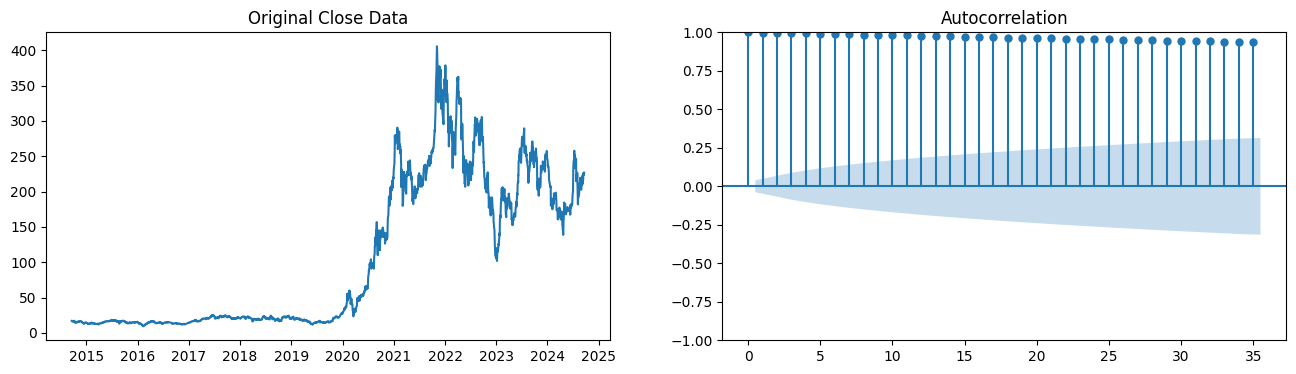

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
def plot_original_close_data_acf(data):
    """
    Plots the original close data and its autocorrelation function (ACF).

    Parameters:
    - data: Pandas Series containing the 'Close' prices

    Returns:
    - None
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.plot(data)
    ax1.set_title("Original Close Data")

    plot_acf(data, ax=ax2)
    plt.show()

# Example function call
plot_original_close_data_acf(data_tesla['Close'])

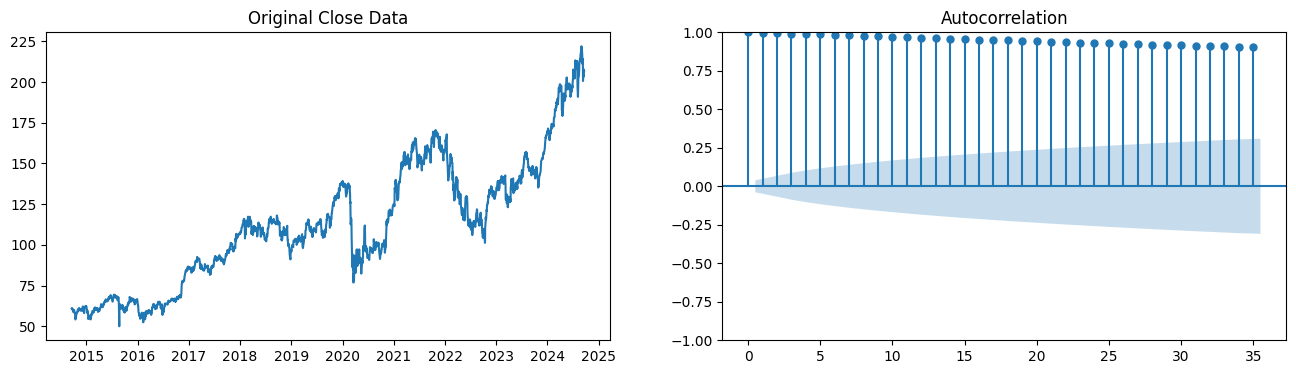

In [ ]:
# function call plot the orginal close data
plot_original_close_data_acf(data_jpm['Close'])

**FIRST DIFFERENCING**

Processing Tesla Data:


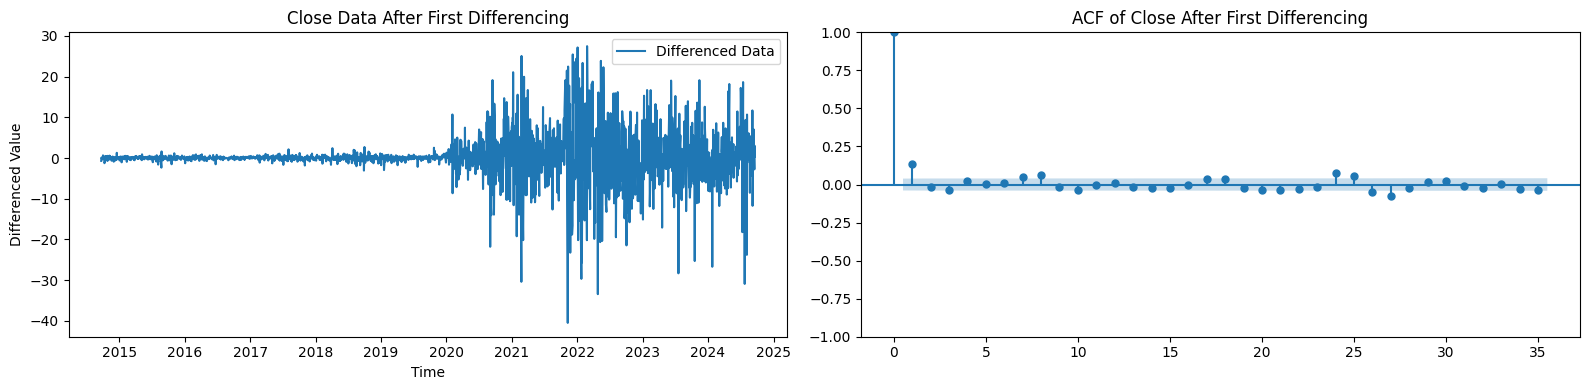

ADF Test Statistic = -10.228629654984118
p-value = 5.0978855024200055e-18
The series is Stationary
Critical Value (1%): -3.4329810529006184
Critical Value (5%): -2.862702382731847
Critical Value (10%): -2.5673887817601657

Processing JP Morgan Data:


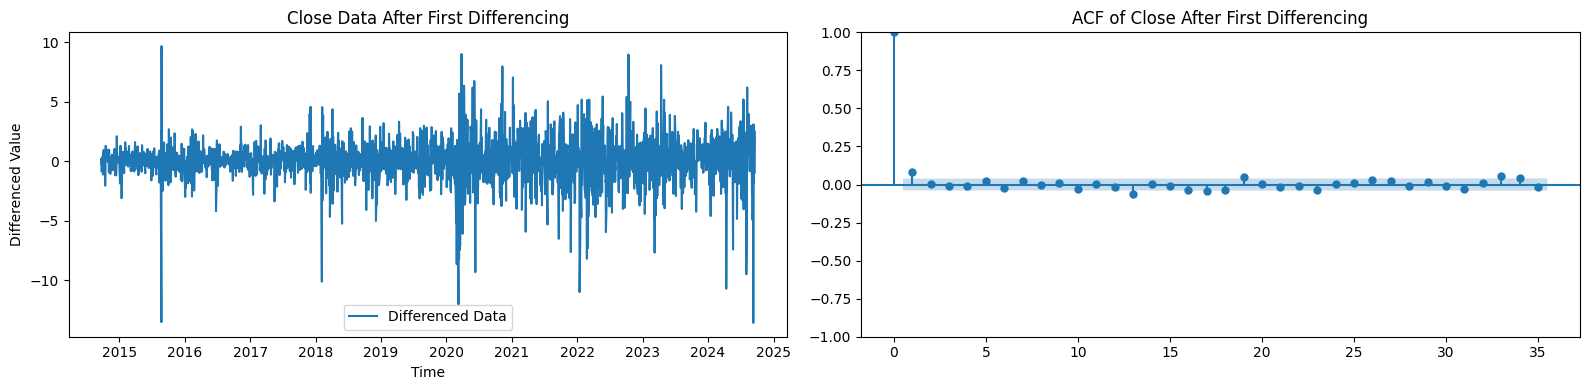

ADF Test Statistic = -46.2406532745773
p-value = 0.0
The series is Stationary
Critical Value (1%): -3.4329538144697187
Critical Value (5%): -2.8626903542179405
Critical Value (10%): -2.567382377622466


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

def process_and_test_stationarity(data, column='Close'):
    """
    Differentiates the data, plots ACF, and tests for stationarity using the Augmented Dickey-Fuller test.

    Parameters:
    - data (pandas.DataFrame or pandas.Series): The dataset or series to analyze.
    - column (str): Column name to analyze, required if input is a DataFrame.

    Returns:
    - diff_data (pandas.Series): Differenced data.
    - adf_statistic (float): ADF test statistic.
    - p_value (float): p-value from the ADF test.
    - is_stationary (str): Stationarity status ('Stationary' or 'Non-Stationary').
    - crit_values (dict): Critical values for the ADF test.
    """
    # Extract the column if a DataFrame is passed
    if isinstance(data, pd.DataFrame):
        series = data[column]
    else:
        series = data

    # Perform first differencing
    diff_data = series.diff().dropna()

    # Plot the differenced data and its ACF
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.plot(diff_data, label='Differenced Data')
    ax1.set_title(f"{column} Data After First Differencing")
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Differenced Value')
    ax1.legend()

    plot_acf(diff_data, ax=ax2)
    ax2.set_title(f"ACF of {column} After First Differencing")
    plt.tight_layout()
    plt.show()

    # Perform the ADF test
    result = adfuller(diff_data)
    adf_statistic, p_value, crit_values = result[0], result[1], result[4]

    # Determine if the series is stationary
    is_stationary = "Stationary" if p_value < 0.05 else "Non-Stationary"

    # Print the results
    print(f"ADF Test Statistic = {adf_statistic}")
    print(f"p-value = {p_value}")
    print(f"The series is {is_stationary}")
    for key, value in crit_values.items():
        print(f"Critical Value ({key}): {value}")

    return diff_data, adf_statistic, p_value, is_stationary, crit_values

# Example function calls
print("Processing Tesla Data:")
tesla_diff_data, tesla_adf_stat, tesla_p_val, tesla_stationary, tesla_crit = process_and_test_stationarity(data_tesla, column='Close')

print("\nProcessing JP Morgan Data:")
jpm_diff_data, jpm_adf_stat, jpm_p_val, jpm_stationary, jpm_crit = process_and_test_stationarity(data_jpm, column='Close')


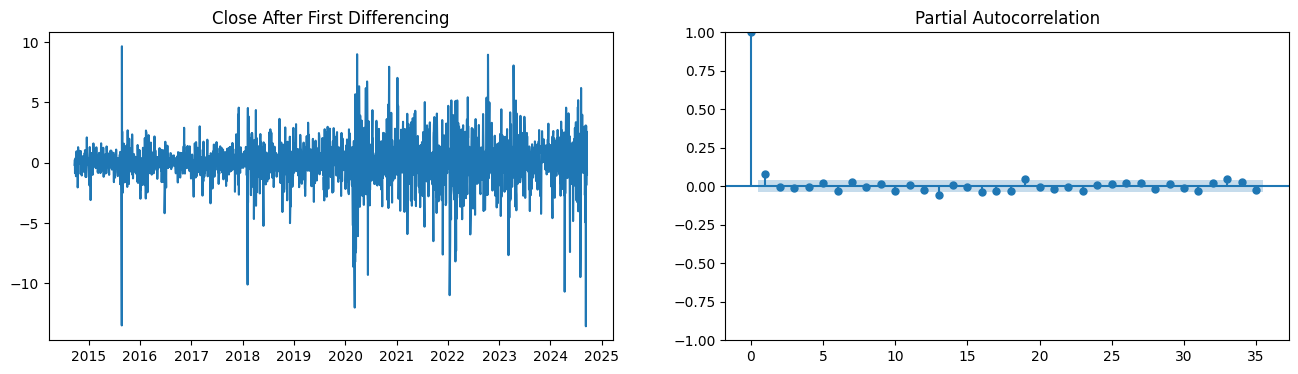

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

def plot_close_after_difference_pacf(data):
    """
    Plots the close data after the first differencing and its partial autocorrelation function (PACF).

    Parameters:
    - data: Pandas Series containing the time series data after differencing

    Returns:
    - None
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.plot(data)
    ax1.set_title("Close After First Differencing")

    ax2.set_ylim(0, 1)
    plot_pacf(data, ax=ax2)
    plt.show()

# Example function call
plot_close_after_difference_pacf(data_jpm['Close'].diff().dropna())

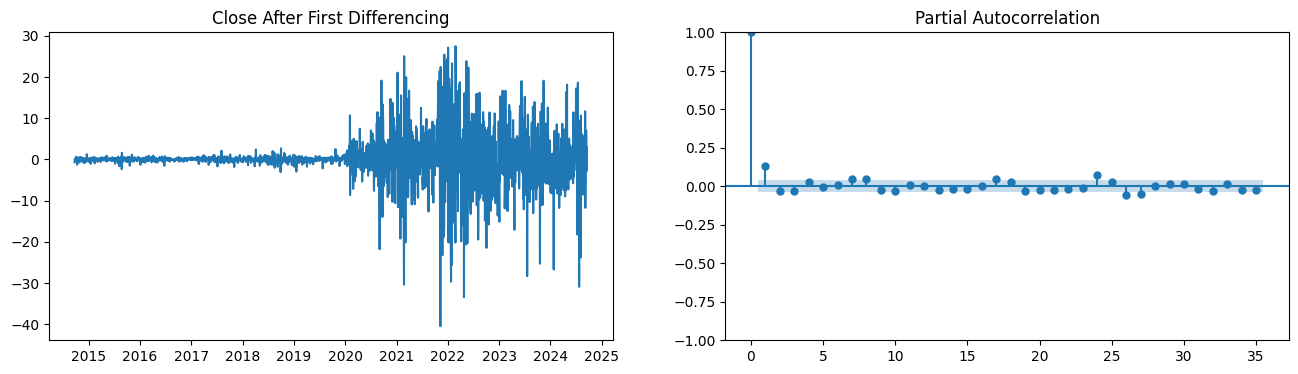

In [ ]:
# Example function call
plot_close_after_difference_pacf(data_tesla['Close'].diff().dropna())

In [ ]:
def find_best_arima_model(data, stationary=True, seasonal=False, start_p=1, start_q=1, max_p=8, max_q=8, d=1):
    """
    Uses auto_arima to find the best ARIMA model.

    Parameters:
    - data (pandas.Series): Time series data.
    - stationary (bool): Whether the data is stationary.
    - seasonal (bool): Whether to consider seasonality in the model.
    - start_p (int): Starting value of AR term.
    - start_q (int): Starting value of MA term.
    - max_p (int): Maximum value of AR term.
    - max_q (int): Maximum value of MA term.
    - d (int): Degree of differencing.

    Returns:
    - best_p, best_d, best_q (tuple): Best parameters (p, d, q).
    - autoarima_model (ARIMA object): Fitted auto_arima model.
    """
    autoarima_model = auto_arima(
        data,
        stationary=stationary,
        seasonal=seasonal,
        start_p=start_p,
        start_q=start_q,
        max_p=max_p,
        max_q=max_q,
        d=d,
        suppress_warnings=True
    )
    best_order = autoarima_model.order
    best_p, best_d, best_q = best_order
    print(f"Best values for p, d, q: {best_p}, {best_d}, {best_q}")
    print(autoarima_model.summary())
    return best_p, best_d, best_q, autoarima_model
print("Processing Tesla Data:")

best_p_tesla, best_d_tesla, best_q_tesla, tesla_arima_model = find_best_arima_model(tesla_diff_data)



Processing Tesla Data:
Best values for p, d, q: 0, 0, 1
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2515
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -7715.839
Date:                Fri, 15 Nov 2024   AIC                          15435.678
Time:                        21:47:37   BIC                          15447.338
Sample:                             0   HQIC                         15439.910
                               - 2515                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1366      0.011     12.777      0.000       0.116       0.158
sigma2        27.0577      0.331     81.649      0.000      26.408      27.

In [ ]:
print("\nProcessing JP Morgan Data:")

best_p_jpm, best_d_jpm, best_q_jpm, jpm_arima_model = find_best_arima_model(jpm_diff_data)


Processing JP Morgan Data:
Best values for p, d, q: 0, 0, 1
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2515
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -5036.074
Date:                Fri, 15 Nov 2024   AIC                          10078.147
Time:                        21:47:40   BIC                          10095.637
Sample:                             0   HQIC                         10084.495
                               - 2515                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0579      0.041      1.426      0.154      -0.022       0.137
ma.L1          0.0805      0.011      7.294      0.000       0.059    